In [1]:
import numpy as np
import torch
import sys
sys.path.append('../')
from voting_games.werewolf_env_v0 import parrallel_raw_env, Roles
import random
from tqdm import tqdm

/root/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Agent(torch.nn.Module):
    def __init__(self, approval_states, num_players, obs_size):
        super().__init__()

        self.critic = torch.nn.Sequential(
            self._layer_init(torch.nn.Linear(obs_size+1, 256)),
            torch.nn.Tanh(),
            self._layer_init(torch.nn.Linear(256,256)),
            torch.nn.Tanh(),
            self._layer_init(torch.nn.Linear(256,1), std=1.0),
        )

        self.actor = torch.nn.Sequential(
            self._layer_init(torch.nn.Linear(obs_size+1, 256)),
            torch.nn.Tanh(),
            self._layer_init(torch.nn.Linear(256,256)),
            torch.nn.Tanh(),
            self._layer_init(torch.nn.Linear(256, approval_states), std=0.01),
        )

        self.num_players = num_players
    
    def get_value(self, x):
        # TODO: We need torch.mean because PPO will use value, and we have a bunch here. 
        #       Do we need to change PPO here?
        return torch.mean(self.critic(torch.stack([torch.cat((torch.tensor([i]), x)) for i in range(self.num_players)])))
    
    # only doing this for the PPO batched call so I don't need extra logic in the regular get action and value
    def get_batched_action_and_value(self, x, actions=None):

        if actions is None:
            raise ValueError("We need batched actions here")

        log_probs = []
        entropies = []
        critics = []
        for current_obs, action in zip(x, actions):
            updated_obs = torch.stack([torch.cat((torch.tensor([i]), current_obs)) for i in range(self.num_players)])

            logits = self.actor(updated_obs)
            probs = torch.distributions.categorical.Categorical(logits=logits)
            
            # update our return tensors
            log_probs.append(torch.sum(probs.log_prob(action)))
            entropies.append(torch.prod(probs.entropy()))
            critics.append(torch.mean(self.critic(updated_obs)))
            
        return actions, torch.stack(log_probs), torch.stack(entropies), torch.stack(critics)

    def convert_actions_to_approvals(self, actions):
        return [-1 if a == 2 else a.item() for a in actions]

    def get_action_and_value(self, x, action=None):
        # could call the network each time, with a different integer for each player?  get approvals that way
        # x is the flattened observation. we should go ahead and run each of the player_ids appended to full obs to get multiple classifications
        # how  to handle entropy here? maybe we multiply all the probs, and then calculate the overall entropy
        # self.critic needs to be changed too, to return an array

        # option to have critic/actors for every single player?

        # option to also delevt n-1 * n-2 for -1s on the wolf
        
        # get logits for every single player in the game.
        x = torch.stack([torch.cat((torch.tensor([i]), x)) for i in range(self.num_players)])
        logits = self.actor(x)
        probs = torch.distributions.categorical.Categorical(logits=logits)

        if action is None:
            action = probs.sample()
        
        # we multiply the entropy, and we add the log_probs together
        # TODO: multiple values for critic. should I average?
        return action, torch.sum(probs.log_prob(action)), torch.prod(probs.entropy()), torch.mean(self.critic(x))

    def _layer_init(self, layer, std=np.sqrt(2), bias_const=0.0):
        torch.nn.init.orthogonal_(layer.weight, std)
        torch.nn.init.constant_(layer.bias, bias_const)
        return layer

In [3]:
def random_policy(observation, agent):
    # these are the other wolves. we cannot vote for them either
    player_status = list(range(len(observation['observation']['player_status'])))
    # dead players
    action_mask = observation['action_mask']
    me = observation['observation']['self_id']

    legal_actions = [action for action,is_alive,is_wolf in zip(player_status, action_mask, observation['observation']['roles']) if is_alive and not is_wolf]
    # wolves don't vote for other wolves. will select another villager at random
    player = random.choice(legal_actions)

    action = [0] * len(action_mask)
    action[me] = 1
    action[player] = -1
    return action

def revenge_wolf_policy(observation, agent, action=None):
    # we already know the agent is a werewolf
    me = observation['observation']['self_id']

    # who voted for me 
    votes_against_me = [i for i, x in enumerate(observation['observation']['votes']) if x == -1 and i == me]

    # remove any wolves who voted for me (they should not have)
    wolf_ids = [i for i, x in enumerate(observation['observation']['roles']) if x == 1 and i != me]
    votes_against_me = list(set(votes_against_me)^set(wolf_ids))

    # remove any players who voted for me but are dead now
    votes_against_me = [i for i in votes_against_me if observation['observation']['player_status'][i] == True]

    villagers_alive = [i for i, x in enumerate(observation['observation']['roles']) \
        if observation['observation']['player_status'][i] == True and x == 0]

    # if there are no votes against me, pick a random villager that is alive
    player_selected = random.choice(votes_against_me) if len(votes_against_me) > 0 else random.choice(villagers_alive)
    choice = [-1] * len(observation['action_mask'])

    choice[me] = 1
    for wid in wolf_ids:
        choice[wid] = 1

    return action if action != None else choice

def random_wolf_policy(observation, agent, action=None):
    # we already know the agent is a werewolf
    wolf_ids = [i for i, x in enumerate(observation['observation']['roles']) if x == 1]
    villagers_alive = [i for i, x in enumerate(observation['observation']['roles']) \
        if observation['observation']['player_status'][i] == True and x == 0]

    # if there are no votes against me, pick a random villager that is alive
    player_selected =  random.choice(villagers_alive)
    choice = [0] * len(observation['observation']['player_status'])
    
    for wid in wolf_ids:
        choice[wid] = 1

    choice[player_selected] = -1

    return action if action != None else choice

In [4]:
env = parrallel_raw_env(num_agents=10, werewolves=2)
env.reset()

num_games = 10000
avg_game_length = 0
wolf_wins = 0
villager_wins = 0

for _ in tqdm(range(num_games)):
    env.reset()
    wolf_brain = {'day': 1, 'phase': 0, 'action': None}
    
    for agent in env.agent_iter():
        observation, reward, termination, truncation, info = env.last()
        
        day = observation['observation']['day']
        phase = observation['observation']['phase']

        if wolf_brain['day'] != day or wolf_brain['phase'] != phase:
            wolf_brain = {'day': day, 'phase': phase, 'action': None}

        role = observation['observation']['roles'][observation['observation']['self_id']]

        if role == Roles.WEREWOLF:
            action = random_wolf_policy(observation, agent, action=wolf_brain['action']) if not termination or truncation else None
            wolf_brain['action'] = action
        else:
            action = random_policy(observation, agent) if not termination or truncation else None

        env.step(action)

    # get some stats
    winner = env.world_state['winners']
    day = env.world_state['day']

    if winner:
        wolf_wins += 1
    else:
        villager_wins += 1
    
    avg_game_length += (day * 1.0)/num_games 

print(f'Average game length = {avg_game_length:.2f}')
print(f'Wolf wins : {wolf_wins}')
print(f'Villager wins: {villager_wins}')

100%|██████████| 10000/10000 [00:34<00:00, 292.31it/s]

Average game length = 4.15
Wolf wins : 9268
Villager wins: 732


In [20]:
env = parrallel_raw_env(num_agents=10, werewolves=2)
env.reset()

num_games = 1000
avg_game_length = 0
wolf_wins = 0
villager_wins = 0

for _ in tqdm(range(num_games)):
    env.reset()
    wolf_brain = {'day': 1, 'phase': 0, 'action': None}
    
    for agent in env.agent_iter():
        observation, reward, termination, truncation, info = env.last()
        
        day = observation['observation']['day']
        phase = observation['observation']['phase']

        if wolf_brain['day'] != day or wolf_brain['phase'] != phase:
            wolf_brain = {'day': day, 'phase': phase, 'action': None}

        role = observation['observation']['roles'][observation['observation']['self_id']]

        if role == Roles.WEREWOLF:
            action = revenge_wolf_policy(observation, agent, action=wolf_brain['action']) if not termination or truncation else None
            wolf_brain['action'] = action
        else:
            action = random_policy(observation, agent) if not termination or truncation else None

        env.step(action)

    # get some stats
    winner = env.world_state['winners']
    day = env.world_state['day']

    if winner:
        wolf_wins += 1
    else:
        villager_wins += 1
    
    avg_game_length += (day * 1.0)/num_games 

print(f'Average game length = {avg_game_length:.2f}')
print(f'Wolf wins : {wolf_wins}')
print(f'Villager wins: {villager_wins}')

100%|██████████| 1000/1000 [00:02<00:00, 430.65it/s]

Average game length = 4.04
Wolf wins : 997
Villager wins: 3


In [19]:
ten_player_env = parrallel_raw_env(num_agents=10, werewolves=1)

avg_game_length = 0
wolf_wins = 0
villager_wins = 0

num_games = 1000

ten_player_env.reset()

for _ in tqdm(range(num_games)):

    for agent in ten_player_env.agent_iter():
        observation, reward, termination, truncation, info = ten_player_env.last()
        action = random_policy(observation, agent) if not termination or truncation else None
        ten_player_env.step(action)
    
    # get some stats
    winner = ten_player_env.world_state['winners']
    day = ten_player_env.world_state['day']

    if winner:
        wolf_wins += 1
    else:
        villager_wins += 1
    
    avg_game_length += (day * 1.0)/num_games 

    # reset 
    ten_player_env.reset()

print(f'Average game length = {avg_game_length:.2f}')
print(f'Wolf wins : {wolf_wins}')
print(f'Villager wins: {villager_wins}')

100%|██████████| 1000/1000 [00:02<00:00, 451.78it/s]

Average game length = 4.15
Wolf wins : 643
Villager wins: 357


## Training on approval

Because we need to generate approvals for every other agent, we will have to call the neural network n-1 times. We should look at batching this, as well as generating the proper observation

maybe we have to call the model n times, but then add the loss together?

In [5]:
def play_and_return_stats(env, wolf_policy, agent_policy, num_games=1000):
    wolf_wins = 0
    villager_wins = 0

    game_replays = []
    loop = tqdm(range(num_games))
    for _ in loop:
        with torch.no_grad():
            env.reset()

            # brain and extra stats 
            wolf_brain = {'day': 1, 'phase': 0, 'action': None}
            
            # magent_list = {agent: [] for agent in env.agents}
            magent_list = {agent : {"self_votes": 0, "dead_votes": 0, "lasted_for": 0} for agent in env.agents if not env.agent_roles[agent]}

            # print(magent_list.keys())
            for magent in env.agent_iter():
                observation, reward, termination, truncation, info = env.last()

                day = observation['observation']['day']
                phase = observation['observation']['phase']

                if wolf_brain['day'] != day or wolf_brain['phase'] != phase:
                    wolf_brain = {'day': day, 'phase': phase, 'action': None}

                role = observation['observation']['roles'][observation['observation']['self_id']]

                # werewolves have full role TODO: add logic for wolves herevisibility
                if role == Roles.WEREWOLF:
                    # action = revenge_wolf_policy(observation, magent, action=wolf_brain['action']) if not termination or truncation else None
                    # wolf_brain['action'] = action
                    # action = random_policy(observation, magent) if not termination or truncation else None

                    action = wolf_policy(observation, None, action=wolf_brain['action']) if not termination or truncation else None
                    wolf_brain['action'] = action
                else:
                    # action = true_random_policy(observation, agent) if not termination or truncation else None
                    obs = torch.Tensor(env.convert_obs(observation['observation']))
                    if not termination or truncation:
                        action, logprobs, _, value = agent_policy.get_action_and_value(obs)
                        action = agent_policy.convert_actions_to_approvals(action)
                    else:
                        action = None
                        
                env.step(action)
            
        game_replays.append(env.history)


        # POST GAME STATS #
        winner = env.world_state['winners']
        day = env.world_state['day']

        if winner:
            wolf_wins += 1
        else:
            villager_wins += 1
        loop.set_description(f"Villager wins {villager_wins}")
        
    return wolf_wins, villager_wins, game_replays


env = parrallel_raw_env(num_agents=10, werewolves=2)
env.reset()
num_agents = 10
observation_size = env.convert_obs(env.observation_spaces['player_1'].sample()['observation']).shape[-1]

# Learner Setup
ppo_agent = Agent(num_players=num_agents, approval_states= 3, obs_size=observation_size)
# ppo_agent = torch.load("ppo_agent")

wwins, vwins, game_replay = play_and_return_stats(env, random_wolf_policy, ppo_agent, num_games=2)
print(f'Wolf wins : {wwins}, Villager wins : {vwins}')


Villager wins 0: 100%|██████████| 2/2 [00:00<00:00, 11.38it/s]

Wolf wins : 2, Villager wins : 0


## Training the agent now

In [29]:
import mlflow

#mlflow.set_tracking_uri("http://mlflow:5000")

In [79]:
ent_coef = 0.1 #
vf_coef = 0.1 #
clip_coef = 0.1 #
gamma = 0.99 #
gae_lambda = 0.95
batch_size = 32 #
max_cycles = 125 #
total_episodes = 10000 #
update_epochs = 3 #

# stats to keep track of for custom metrics
self_voting = []
dead_voting = []

avg_game_length = 0
wolf_wins = 0
villager_wins = 0

env = parrallel_raw_env(num_agents=10, werewolves=2)
env.reset()
num_agents = 10
observation_size = env.convert_obs(env.observation_spaces['player_1'].sample()['observation']).shape[-1]

# Learner Setup
parallel_ppo_agent = Agent(num_players=num_agents, approval_states= 3, obs_size=observation_size)
optimizer = torch.optim.Adam(ppo_agent.parameters(), lr=0.001, eps=1e-5)


with mlflow.start_run(run_name='Approval Training Random Wolf behavior'):
    for episode in tqdm(range(total_episodes)):
        with torch.no_grad():
            env.reset()

            # brain and extra stats 
            wolf_brain = {'day': 1, 'phase': 0, 'action': None}
            self_votes = 0
            
            # magent_list = {agent: [] for agent in env.agents}
            magent_list = {agent : [] for agent in env.agents if not env.agent_roles[agent]}

            # print(magent_list.keys())
            for magent in env.agent_iter():
                observation, reward, termination, truncation, info = env.last()

                day = observation['observation']['day']
                phase = observation['observation']['phase']

                if wolf_brain['day'] != day or wolf_brain['phase'] != phase:
                    wolf_brain = {'day': day, 'phase': phase, 'action': None}

                role = observation['observation']['roles'][observation['observation']['self_id']]

                # werewolves have full role TODO: add logic for wolves herevisibility
                if role == Roles.WEREWOLF:
                    # action = revenge_wolf_policy(observation, magent, action=wolf_brain['action']) if not termination or truncation else None
                    # wolf_brain['action'] = action
                    # action = random_policy(observation, magent) if not termination or truncation else None

                    game_action = random_wolf_policy(observation, magent, action=wolf_brain['action']) if not termination or truncation else None
                    wolf_brain['action'] = game_action
                else:
                    obs = torch.Tensor(env.convert_obs(observation['observation']))
                    if not termination or truncation:
                        action, logprobs, _, value = parallel_ppo_agent.get_action_and_value(obs)
                        game_action = parallel_ppo_agent.convert_actions_to_approvals(action)
                    else:
                        action = None
                        game_action = None

                    # grab some villager stats we think are useful
                    # TODO : THIS only works if you have a -1 approval for your own ID
                    if action != None and action[observation['observation']['self_id']] == -1:
                        self_votes += 1
                
                    # TODO : Do not care about dead votes yet
                    # if action in [i for i, status in enumerate(observation['observation']['player_status']) if status == False]:
                    #     dead_votes += 1

                    magent_list[magent].append({
                        "obs": obs, 
                        "action": action,
                        "prev_reward": reward,
                        "logprobs": logprobs,
                        "term": termination,
                        "value": value
                        })

                env.step(game_action)
            
            # take the sequential observations of each agent, and store them appropriately
            magent_obs = {agent: {'obs': [], 'rewards': [], 'actions': [], 'logprobs': [], 'values': [], 'terms': []} for agent in magent_list}
            for key, value in magent_list.items():
                # print(f'-- {key} --')
                for s1, s2 in zip(value, value[1:]):
                    magent_obs[key]['obs'].append(s1['obs'])
                    magent_obs[key]['rewards'].append(s2['prev_reward'])
                    magent_obs[key]['actions'].append(s1['action'])
                    magent_obs[key]['logprobs'].append(s1['logprobs'])
                    magent_obs[key]['values'].append(s1['value'])
                    magent_obs[key]['terms'].append(s2['term'])


        # POST GAME STATS #
        winner = env.world_state['winners']
        day = env.world_state['day']

        self_voting.append(self_votes)

        if winner:
            wolf_wins += 1
        else:
            villager_wins += 1
        
        avg_game_length += (day * 1.0)/total_episodes
        # END OF POST GAME STATS #

        mlflow.log_metric("avg_game_len", f'{avg_game_length:.2f}')
        mlflow.log_metric("avg_self_votes", f'{sum(self_voting)/len(self_voting)}')
        mlflow.log_metric("wolf wins", wolf_wins)
        mlflow.log_metric("villager wins", villager_wins)
        if episode % 50 == 0:
            #wwins, vwins = play_and_return_stats(env, random_wolf_policy, ppo_agent, num_games=100)
            #mlflow.log_metric("wwins", wwins)
            #mlflow.log_metric("vwins", vwins)
            continue
        
        

        # We will do this for each agent in the episode
        # essentially we are calculating advantages and returns
        with torch.no_grad():
            for player, records in magent_obs.items():
                # print(f'{records}')
                advantages = torch.zeros_like(torch.tensor(records['rewards']))

                for t in reversed(range(len(records['obs']))):
                    # print(f'T: {t+1} - Rewards : {torch.tensor(records["rewards"])[t+1]} ')
                    # not using terms, as these are episodic

                    ## this was the last one. We are not using any terminal states in a good way

                    if t == len(records['obs']) - 1:
                        #print(f'T: {t} - Rewards at end : {torch.tensor(records["rewards"])[t]} ')
                        #print(f'T: {t} - Actions at end : {torch.tensor(records["actions"])[t]} ')
                        delta = records["rewards"][t] - records["values"][t]
                        advantages[t]  = delta
                    else:
                        #print(f'T: {t} - Rewards : {torch.tensor(records["rewards"])[t]} ')
                        #print(f'T: {t} - Actions : {torch.tensor(records["actions"])[t]} ')                    
                        delta = records["rewards"][t] + gamma * records["values"][t+1] - records["values"][t]
                        advantages[t]  = delta + gamma * gamma * advantages[t+1]

                    #delta = records['rewards'][t] + gamma * records['values'][t+1] - records['values'][t]
                magent_obs[player]["advantages"] = advantages
                magent_obs[player]["returns"] = advantages + torch.tensor(records["values"])
                    #advantages[t] = delta + gamma * gamma * advantages[t+1]
        

        # new logic, maybe we do this after a couple of games, so we get more data overall?
        

        # optimize the policy and the value network now
        # we can take all our observations now and flatten them into one bigger list of individual transitions
        # TODO: could make this setting into a single loop, but maybe this is clearer. ALso could make all these tensors earlier
        b_observations = torch.cat([torch.stack(item['obs']) for item in magent_obs.values()])
        b_logprobs = torch.cat([torch.stack(item['logprobs']) for item in magent_obs.values()])
        b_actions = torch.cat([torch.stack(item['actions']) for item in magent_obs.values()])
        b_returns = torch.cat([item['returns'] for item in magent_obs.values()])
        b_values = torch.cat([torch.stack(item['values']) for item in magent_obs.values()])
        b_advantages =  torch.cat([item['advantages'] for item in magent_obs.values()])



        # b_index stands for batch index
        b_index = np.arange(len(b_observations))
        clip_fracs = []
        for epoch in range(update_epochs):
            np.random.shuffle(b_index)
            for start in range(0, len(b_observations), batch_size):
                end = start + batch_size
                batch_index = b_index[start:end]

                # TODO: batched actions, How to handle batched observations and acctions properly in the agent
                #       Maybe a different 

                # newlogprob needs to return a list of logprobs
                _, newlogprob, entropy, value = parallel_ppo_agent.get_batched_action_and_value(
                    b_observations[batch_index], b_actions[batch_index])
                
                logratio = newlogprob - b_logprobs[batch_index]
                ratio = logratio.exp()

                with torch.no_grad():
                    # calculate approx_kl http://joschu.net/blog/kl-approx.html
                    old_approx_kl = (-logratio).mean()
                    approx_kl = ((ratio - 1) - logratio).mean()
                    clip_fracs += [
                        ((ratio - 1.0).abs() > clip_coef).float().mean().item()
                    ]
                
                # normalizing advantages
                advantages = b_advantages[batch_index]
                advantages = advantages.float()
                advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

                # policy loss
                pg_loss1 = -advantages * ratio
                pg_loss2 = -advantages * torch.clamp(ratio, 1 - clip_coef, 1 + clip_coef)
                pg_loss = torch.max(pg_loss1, pg_loss2).mean()

                # value loss
                value = value.flatten()
                v_loss_unclipped = (value - b_returns[batch_index]) ** 2
                v_clipped = b_values[batch_index] + torch.clamp(
                    value - b_values[batch_index],
                    -clip_coef,
                    clip_coef,
                )
                v_loss_clipped = (v_clipped - b_returns[batch_index]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()

                entropy_loss = entropy.mean()
                loss = pg_loss - ent_coef * entropy_loss + v_loss * vf_coef

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
        # could move them from GPU here
        y_pred, y_true = b_values.numpy(), b_returns.numpy()
        var_y = np.var(y_true)
        explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y
        
        # if episode % 20 == 0:
            # print(f"Training episode {episode}")
            # #print(f"Episodic Return: {np.mean(total_episodic_return)}")
            # #print(f"Episode Length: {end_step}")
            # print("")
            # print(f"Value Loss: {v_loss.item()}")
            # print(f"Policy Loss: {pg_loss.item()}")
            # print(f"Old Approx KL: {old_approx_kl.item()}")
            # print(f"Approx KL: {approx_kl.item()}")
            # print(f"Clip Fraction: {np.mean(clip_fracs)}")
            # print(f"Explained Variance: {explained_var.item()}")
            # print("\n-------------------------------------------\n")

            # also check some stats and try to log these

    # At the end, print some stuff here for overall stats

    print(f'Average game length = {avg_game_length:.2f}')
    print(f'Wolf wins : {wolf_wins}')
    print(f'Villager wins: {villager_wins}')
    print(f'Avg amount of self votes a game across villagers: {sum(self_voting)/len(self_voting)}')

torch.save(parallel_ppo_agent, "long_approval_agent")

100%|██████████| 30000/30000 [2:06:11<00:00,  3.96it/s]  

Average game length = 4.19
Wolf wins : 27777
Villager wins: 2223
Avg amount of self votes a game across villagers: 0.0


In [78]:
env = parrallel_raw_env(num_agents=10, werewolves=2)
env.reset()
# num_agents = 10
# observation_size = env.convert_obs(env.observation_spaces['player_1'].sample()['observation']).shape[-1]

# Learner Setup
# ppo_agent = Agent(num_actions=num_actions, obs_size=observation_size)
ppo_agent = torch.load("approval_agent")

wwins, vwins, replay = play_and_return_stats(env, random_wolf_policy, ppo_agent, num_games=10000)
print(f'Wolf wins : {wwins}, Villager wins : {vwins}')

100%|██████████| 10000/10000 [10:07<00:00, 16.47it/s]

Wolf wins : 8689, Villager wins : 1311


Lets run the random wolf and random villager 100 times for 1000 games and average the villager wins.
We will do the same for the approval agent, and the long_approval_agent

In [81]:
env = parrallel_raw_env(num_agents=10, werewolves=2)
env.reset()

num_times = 100
num_games = 1000
avg_game_length = 0

villager_win_list = []
for _ in tqdm(range(num_times)):

    villager_wins = 0
    wolf_wins = 0
    for _ in range(num_games):
        env.reset()
        wolf_brain = {'day': 1, 'phase': 0, 'action': None}
        
        for agent in env.agent_iter():
            observation, reward, termination, truncation, info = env.last()
            
            day = observation['observation']['day']
            phase = observation['observation']['phase']

            if wolf_brain['day'] != day or wolf_brain['phase'] != phase:
                wolf_brain = {'day': day, 'phase': phase, 'action': None}

            role = observation['observation']['roles'][observation['observation']['self_id']]

            if role == Roles.WEREWOLF:
                action = random_wolf_policy(observation, agent, action=wolf_brain['action']) if not termination or truncation else None
                wolf_brain['action'] = action
            else:
                action = random_policy(observation, agent) if not termination or truncation else None

            env.step(action)

        # get some stats
        winner = env.world_state['winners']
        day = env.world_state['day']

        if winner:
            wolf_wins += 1
        else:
            villager_wins += 1
        
    villager_win_list.append(villager_wins)    

print(f' Average villager wins in 1000 games : {np.mean(villager_win_list)}')
# print(f'Average game length = {avg_game_length:.2f}')
# print(f'Wolf wins : {wolf_wins}')
# print(f'Villager wins: {villager_wins}')

100%|██████████| 100/100 [10:36<00:00,  6.36s/it]

 Average villager wins in 1000 games : 65.04


In [82]:
print(f' Average villager wins in 1000 games : {np.mean(villager_win_list)}')

 Average villager wins in 1000 games : 65.04


In [84]:
env = parrallel_raw_env(num_agents=10, werewolves=2)
env.reset()
ppo_agent = torch.load("approval_agent")


num_times = 100
num_games = 1000
avg_game_length = 0

villager_win_list = []
for _ in tqdm(range(num_times)):
    wwins, vwins, replay = play_and_return_stats(env, random_wolf_policy, ppo_agent, num_games=num_games)
    villager_win_list.append(vwins)

print(f' Average villager wins in 1000 games : {np.mean(villager_win_list)}')

100%|██████████| 100/100 [1:44:44<00:00, 62.85s/it]

 Average villager wins in 1000 games : 132.29


In [85]:
print(f' Average villager wins in 1000 games : {np.mean(villager_win_list)}')

 Average villager wins in 1000 games : 132.29


In [30]:
env = parrallel_raw_env(num_agents=10, werewolves=2)
env.reset()
ppo_agent = torch.load("long_approval_agent")


num_times = 10
num_games = 100
avg_game_length = 0

villager_win_list = []
for _ in tqdm(range(num_times)):
    wwins, vwins, replay = play_and_return_stats(env, random_wolf_policy, ppo_agent, num_games=num_games)
    villager_win_list.append(vwins)

print(f' Average villager wins in 1000 games : {np.mean(villager_win_list)}')

100%|██████████| 10/10 [01:13<00:00,  7.39s/it]

 Average villager wins in 1000 games : 7.5


In [87]:
print(f' Average villager wins in 1000 games : {np.mean(villager_win_list)}')

 Average villager wins in 1000 games : 129.95


In [99]:
replay[0][-1]

{'day': 3,
 'phase': 2,
 'alive': ['player_2', 'player_4', 'player_6', 'player_8'],
 'killed': ['player_7', 'player_0', 'player_3'],
 'executed': ['player_1', 'player_9', 'player_5'],
 'werewolves': ['player_4', 'player_6'],
 'villagers': ['player_0',
  'player_1',
  'player_2',
  'player_3',
  'player_5',
  'player_7',
  'player_8',
  'player_9'],
 'votes': {'player_4': [0, 0, 0, -1, 1, 0, 1, 0, 0, 0],
  'player_6': [0, 0, 0, -1, 1, 0, 1, 0, 0, 0]},
 'winners': <Roles.WEREWOLF: 1>}

In [110]:
villager_wins = [r for r in replay if r[-1]["winners"] == 0]

In [27]:
from collections import Counter
import matplotlib.pyplot as plt

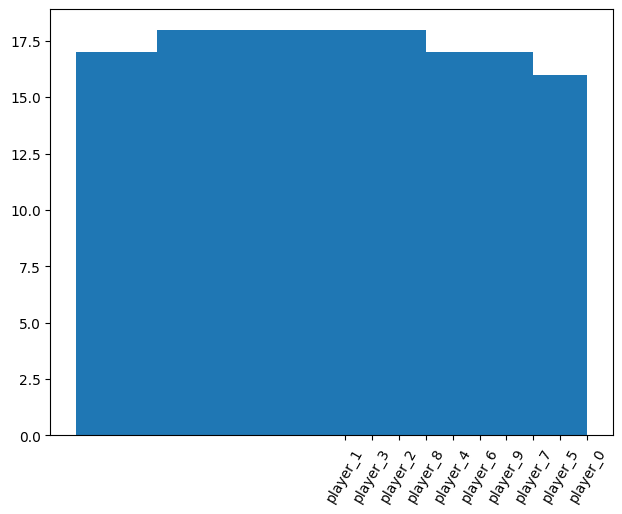

In [29]:
labels, values = zip(*Counter([item for sublist in [villager_win[-1]["werewolves"] for villager_win in villager_wins] for item in sublist]).items())
indexes = np.arange(len(labels))
width = num_agents

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.tight_layout()
plt.xticks(rotation=60)
plt.show()

In [21]:
env = parrallel_raw_env(num_agents=10, werewolves=2)
env.reset()
ppo_agent = torch.load("long_approval_agent")


num_times = 100
num_games = 1000
avg_game_length = 0

wwins, vwins, replay = play_and_return_stats(env, random_wolf_policy, ppo_agent, num_games=num_games)

In [24]:
villager_wins = [r for r in replay if r[-1]["winners"] == 0]

In [25]:
len(villager_wins)

78

In [26]:
villager_wins[0]

[{'day': 1,
  'phase': <Phase.ACCUSATION: 0>,
  'alive': ['player_0',
   'player_1',
   'player_2',
   'player_3',
   'player_4',
   'player_5',
   'player_6',
   'player_7',
   'player_8',
   'player_9'],
  'killed': [],
  'executed': [],
  'werewolves': ['player_1', 'player_3'],
  'villagers': ['player_0',
   'player_2',
   'player_4',
   'player_5',
   'player_6',
   'player_7',
   'player_8',
   'player_9'],
  'votes': {},
  'winners': None},
 {'day': 1,
  'phase': <Phase.ACCUSATION: 0>,
  'alive': ['player_0',
   'player_1',
   'player_2',
   'player_3',
   'player_4',
   'player_5',
   'player_6',
   'player_7',
   'player_8',
   'player_9'],
  'killed': [],
  'executed': [],
  'werewolves': ['player_1', 'player_3'],
  'villagers': ['player_0',
   'player_2',
   'player_4',
   'player_5',
   'player_6',
   'player_7',
   'player_8',
   'player_9'],
  'votes': {'player_0': [-1, -1, -1, 0, 0, -1, -1, 1, -1, -1],
   'player_1': [0, 1, 0, 1, 0, -1, 0, 0, 0, 0],
   'player_2': [1, 0, 